In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import altair as alt

import bootcamp_utils

In [15]:
df = pd.read_csv('data/grant_complete.csv', comment='#')

df.head()

,band,beak depth (mm),beak length (mm),species,year
0,20123,8.05,9.25,fortis,1973
1,20126,10.45,11.35,fortis,1973
2,20128,9.55,10.15,fortis,1973
3,20129,8.75,9.95,fortis,1973
4,20133,10.15,11.55,fortis,1973


In [16]:
df = df.loc[(df['species']=='scandens') & (df['year'].isin([1975, 2012])),
            ['year', 'beak depth (mm)']]
df.head()

,year,beak depth (mm)
401,1975,8.4
402,1975,8.8
403,1975,8.4
404,1975,8.0
405,1975,7.9


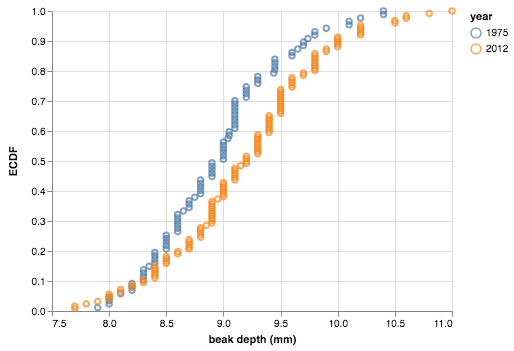

In [17]:
# Compute ECDF
df['ECDF'] = df.groupby('year').transform(bootcamp_utils.ecdf_y)

# Make a plot
alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('beak depth (mm):Q', 
                scale=alt.Scale(zero=False)),
        y='ECDF:Q',
        color='year:N')

Looks like the beak depth is larger in 2012, but we want to get some descriptive stats to help us understand the result

In [18]:
bd_1975 = df.loc[df['year'] == 1975, 'beak depth (mm)'].values
bd_2012 = df.loc[df['year'] == 2012, 'beak depth (mm)'].values

np.mean(bd_1975), np.mean(bd_2012)

(8.959999999999999, 9.188492063492063)

Looks like we do have a difference, but can we confirm it is statistically relevant? This is where hackerstats comes in...

This will figure out our confidence intervals

What we do is rely on the computer to experiment for us: simulates redoing this experiment many many times and determines where our parameters fall

Bootstrapping in three steps
1 - draw n points out of your dataset WITH replacement = "bootstrap sample"
2 - compute your quantity or statistic over that sample = "bootstrap replicate"
3 - repeat

Doing this proceedure will allow us to answer this question: "if we were to do this experiment again under identical conditions, are we likely to get the same results?"

We are sampling out of the empirical distribution function to address this

In [20]:
np.random.seed(42)  #normally don't set the seed
bs_sample = np.random.choice(bd_1975, replace=True, size=len(bd_1975))
bs_sample

array([ 9.7 ,  9.7 ,  9.8 ,  8.3 ,  8.9 ,  9.45,  8.35,  9.44,  9.44,
        8.7 ,  8.4 ,  9.1 ,  9.1 ,  8.8 ,  9.9 ,  9.1 ,  8.8 ,  8.6 ,
        8.1 ,  8.9 ,  8.4 ,  9.04,  8.  ,  9.1 , 10.2 ,  9.1 ,  8.3 ,
        8.1 ,  9.45,  9.7 ,  8.7 ,  8.7 ,  9.2 ,  8.7 ,  9.2 ,  8.2 ,
        8.6 ,  8.4 ,  9.2 ,  8.6 ,  8.9 , 10.4 ,  9.3 ,  9.  ,  8.  ,
        8.1 ,  9.  ,  8.9 ,  9.1 ,  8.8 ,  9.05,  8.1 ,  9.1 ,  9.1 ,
        8.5 ,  9.2 ,  8.5 ,  9.05,  8.65, 10.4 , 10.1 ,  8.  ,  8.8 ,
        8.9 ,  8.5 ,  8.  ,  8.5 ,  8.8 ,  9.  ,  9.1 ,  8.9 ,  8.3 ,
        8.7 ,  9.  ,  8.5 ,  9.7 ,  9.8 ,  9.05,  8.35,  8.7 ,  9.3 ,
        8.75,  9.45,  9.45,  9.1 ,  8.7 ,  8.5 ])

In [21]:
bs_sample.size, bd_1975.size

(87, 87)

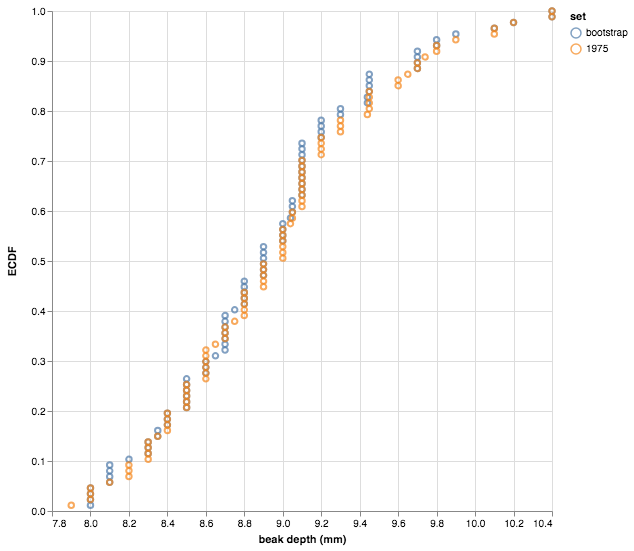

In [28]:
x_bs, y_bs = bootcamp_utils.ecdf_vals(bs_sample)

df_bs = pd.DataFrame(data={'beak depth (mm)': x_bs,
                            'ECDF': y_bs,
                            'set': 'bootstrap',
                            'year': 1975})

df_orig = df.copy().loc[df['year'] == 1975, :]
df_orig['set'] = 1975

df_plot = pd.concat([df_bs, df_orig], ignore_index=True, sort=True)

alt.Chart(df_plot,
          width=500,
          height=500
        ).mark_point(
        ).encode(
            x=alt.X('beak depth (mm):Q', scale=alt.Scale(zero=False)),
            y='ECDF:Q',
            color=('set:N')
        )


In [29]:
np.mean(bs_sample), np.mean(bd_1975)

(8.92609195402299, 8.959999999999999)

In [33]:
n_reps = 100000

bs_reps_1975 = np.empty(n_reps)

for i in range(n_reps):
    bs_sample = np.random.choice(bd_1975, size=len(bd_1975))
    bs_reps_1975[i] = np.mean(bs_sample)

In [34]:
bs_reps_1975

array([8.95954023, 8.95574713, 8.85390805, ..., 9.04862069, 9.02229885,
       9.00954023])

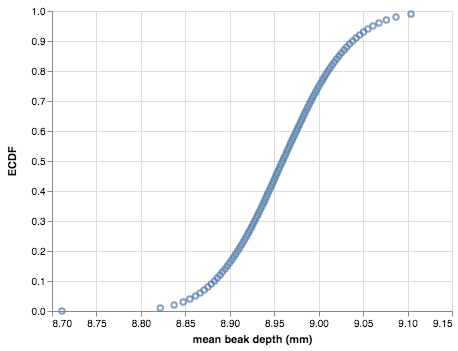

In [35]:
x, y = bootcamp_utils.ecdf_vals(bs_reps_1975)

df_ecdf = pd.DataFrame(data={'mean beak depth (mm)': x[::1000],
                            'ECDF': y[::1000]})

alt.Chart(df_ecdf
         ).mark_point(
    ).encode(
        x=alt.X('mean beak depth (mm):Q', scale=alt.Scale(zero=False)),
        y='ECDF:Q'
)


In [36]:
np.mean(bs_reps_1975), np.percentile(bs_reps_1975, [2.5, 97.5])

(8.96006713678161, array([8.84298851, 9.08103448]))

In [37]:
np.mean(bd_1975) + 1.96 * np.std(bd_1975) / np.sqrt(len(bd_1975))

9.07837473262184

In [38]:
n_reps = 100000

bs_reps_1975 = np.empty(n_reps)

for i in range(n_reps):
    bs_sample = np.random.choice(bd_1975, size=len(bd_1975))
    bs_reps_1975[i] = np.std(bs_sample)

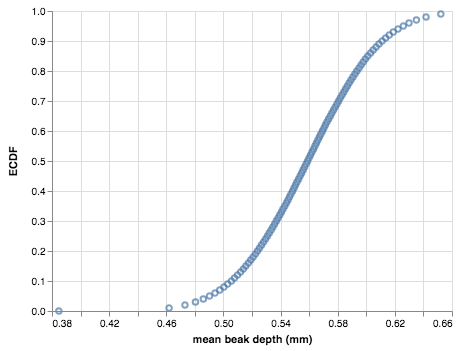

In [39]:
x, y = bootcamp_utils.ecdf_vals(bs_reps_1975)

df_ecdf = pd.DataFrame(data={'mean beak depth (mm)': x[::1000],
                            'ECDF': y[::1000]})

alt.Chart(df_ecdf
         ).mark_point(
    ).encode(
        x=alt.X('mean beak depth (mm):Q', scale=alt.Scale(zero=False)),
        y='ECDF:Q'
)


In [40]:
np.mean(bs_reps_1975), np.percentile(bs_reps_1975, [2.5, 97.5])

(0.5585502747365425, array([0.47705231, 0.63812523]))